In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("../src/")

In [2]:
import matplotsoccer as mps
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
data = "../data/spadl-v2.hdf"
games = pd.read_hdf(data,key="games")
epl16 = games[(games.competition_id == 8) & (games.season_id == 2016)]
epl16[:5]

def get_actions(games, hdf_url):
    actions = []
    for game in tqdm(list(games.itertuples())):
        a = pd.read_hdf(hdf_url, key="actions/" + str(game.id))
        a["left_to_right"] = a["team_id"] == game.home_team_id
        actions.append(a)
    actions = pd.concat(actions)

    #actions = always_ltr(actions)
    return actions


def always_ltr(actions):
    away_idx = ~actions.left_to_right
    actions.loc[away_idx, "start_x"] = 105 - actions[away_idx].start_x.values
    actions.loc[away_idx, "start_y"] = 68 - actions[away_idx].start_y.values
    actions.loc[away_idx, "end_x"] = 105 - actions[away_idx].end_x.values
    actions.loc[away_idx, "end_y"] = 68 - actions[away_idx].end_y.values
    return actions

actions = get_actions(epl16,data)

actiontypes = pd.read_hdf(data, key="actiontypes")
actiontypes.columns = ["type_id","type_name"]
actions = actions.merge(actiontypes, on="type_id")

players = pd.read_hdf(data,key="players")
actions = actions.merge(players,left_on="player_id",right_on="id")

teams = pd.read_hdf(data,key="teams")
actions = actions.merge(teams,left_on="team_id",right_on="id")

actions = actions.sort_values(["game_id","period_id","time_seconds","timestamp"])

actions.columns

/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
100%|██████████| 380/380 [00:04<00:00, 88.45it/s]


Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart',
       'type_id', 'result', 'left_to_right', 'type_name', 'id_x', 'first_name',
       'last_name', 'soccer_name', 'birthday', 'nation_id', 'id_y',
       'full_name', 'short_name', 'abbreviation'],
      dtype='object')

In [4]:
player_actions = actions[actions.last_name.str.contains("Kompany")].copy()
set(player_actions.soccer_name)
player_actions = always_ltr(player_actions)
x,y = player_actions.start_x, player_actions.start_y

# Field

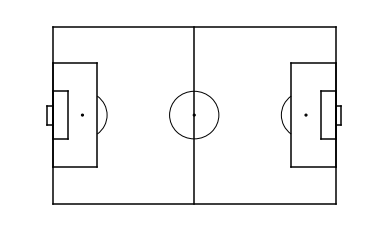

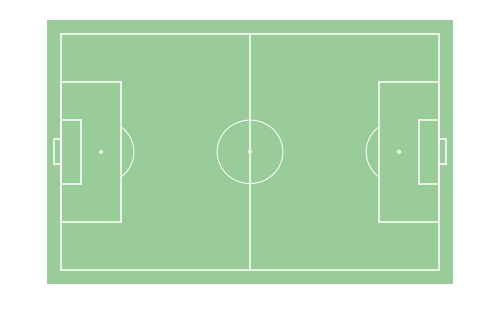

In [5]:
f = mps.field()
f = mps.field(color="green",figsize=8)

# Heatmap

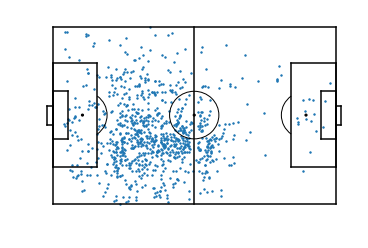

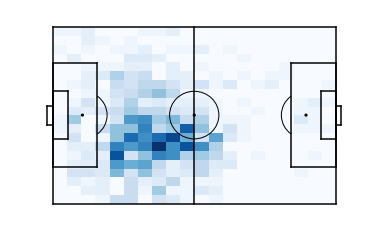

In [6]:
ax = mps.field(show=False)
ax.scatter(x,y,s=2); plt.show()

matrix = mps.count(x,y,n=20,m=20)
hm = mps.heatmap(matrix)

# Actions

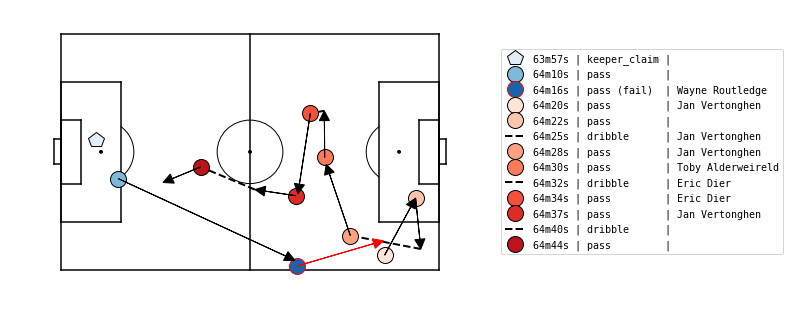

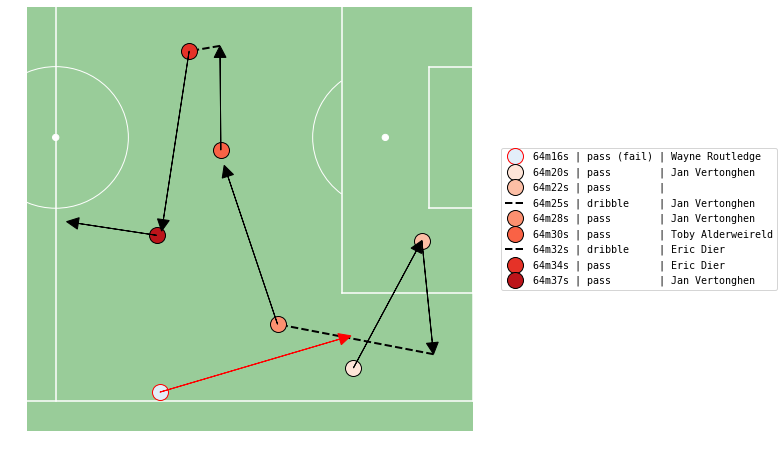

In [39]:
start = 499604
delta = 13
for i in range(1):
    phase = actions[start+i*delta:start+delta+i*delta].copy()
    phase["team"] = phase.full_name
    phase["player"] = phase.soccer_name
    phase = phase[["team","player","time_seconds","type_name","result","start_x","start_y","end_x","end_y"]]

    # Full field
    mps.actions(phase,figsize = 8)

    ## Zoomed in
    mps.actions(phase[2:11],color="green",zoom=True,figsize=8)